## Building A Simple Retrieval Augmented Generator Using OpenAI

Talk with your pdfs!

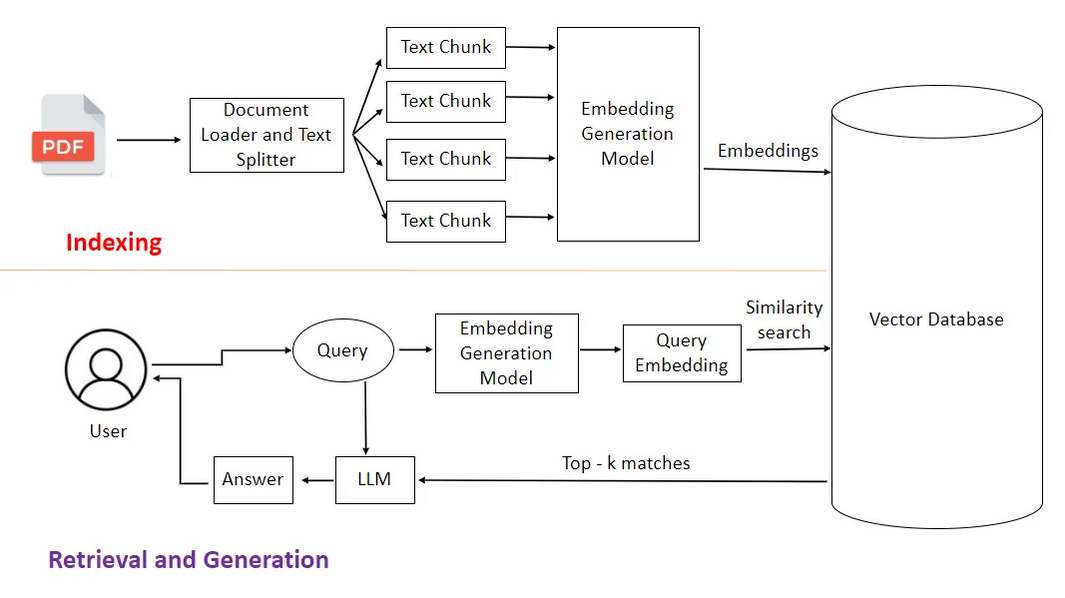

Image Source: [RAG For Your Own Documents](https://medium.com/@pragyashukla2580/rag-retrieval-augmented-generation-for-your-own-documents-5e024267140e)

### Concepts we heard about:

* set up the client with OpenAI key
* setup GoogleDrive and path to pdf file

* Extract the text from a PDF, important take-aways:
  - there are different pdf readers (packages which can be tried out)
  - the one which was used here: each page becomes a single document object
  - stores it with metadata
  - one gets a list with all document objects

* Clean the text - only a little:
  - use .lower, remove whitespace (like new line indicator) and extra tabs

* Split text into chunks:
  - there are different packages, RecursiveCharacterTextSplitter is often used because of the way [it works](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846)
  - optimal chunk size 800-1500
  - don't forget the overlap

* Create embeddings:
  - words need to be represented as numbers for any calculations
  - embeddings are stored in numpy array
  - for every chunk a vector presentation is created

* Build Vector Database:
 - where the embeddings are stored
 - it is an optimized data structure for fast similarity search
 - there are different ones FAISS, ChromaDB, Pinecone, all different when it comes to strengths, architecture

* Search Similar Chunks:
  - the query is embedded with the same model
  - vector database takes the query vector and compares it to allthe chunk vectors in the database
  - finds k chunks whose vectors are closest to the query vector

* Generate Answer:
  - gets query and context
  - includes setup for OpenAI call with definition of system and user
  - temperature is a useful argument to play around with deterministic responses

* Define Build RAG function (goes until building vector database)
* Creating Chat Loop which calls search_chunks and generate_answer

### Install and Import

In [1]:
!pip install openai faiss-cpu langchain-text-splitters langchain-community pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [2]:
import re

In [3]:
import openai
import faiss
import numpy as np
from google.colab import userdata
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

### Setup OpenAI

In [4]:
client = openai.OpenAI(api_key=userdata.get('OpenAI_personal'))

### Setup GoogleDrive and Path

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
path_jnh = "path_to_pdf_on_your_GDrive"

### Extract PDF text

In [26]:
def load_pdf(pdf_path):
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    return documents

One page = one document: Each page of the PDF becomes a separate Document object

Content: The page_content field contains the extracted text from that page

Metadata: Each document gets metadata like:

- source: the file path
- page: the page number (0-indexed)

Returns a list: You get back a list of Document objects

### Clean the Text (a little)

In [27]:
def clean_text(text):
    text_lower = text.lower()
    text_normalized_tabs = re.sub(r'(\t)+', '', text_lower) # remove multiple consecutive tabs
    text_clean = re.sub(r'\s+', ' ', text_normalized_tabs) # replace any whitespace sequence with exactly one space
    return text_clean.strip()

### Let's have a look at an example

In [28]:
text_pdf = load_pdf(path_jnh)

#### Raw text of first document object (first page)

In [29]:
example_page = text_pdf[0]
example_page

Document(metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 18.0 (Windows)', 'creationdate': '2023-07-12T08:04:59+02:00', 'crossmarkdomains[1]': 'springer.com', 'crossmarkdomains[2]': 'springerlink.com', 'crossmarkdomainexclusive': 'true', 'crossmarkmajorversiondate': '2010-04-23', 'moddate': '2023-07-12T08:06:51+02:00', 'trapped': '/False', 'doi': '10.1007/s10462-022-10272-8', 'source': '/content/drive/MyDrive/Capstone engageability/s10462-022-10272-8.pdf', 'total_pages': 43, 'page': 0, 'page_label': '9497'}, page_content='Published online:   \n© The Author(s), under exclusive licence to Springer Nature B.V. 2022\n \r Zeshui Xu\nxuzeshui@263.net\nYuanhang Zheng\nyuanhang_zheng@foxmail.com\nAnran Xiao\nxiaoanran_ubby@163.com\n1 College of Computer Science, Sichuan University, 610064 Chengdu, PR China\n2 Business School, Sichuan University, 610064 Chengdu, PR China\nDeep learning in economics: a systematic and critical review\nYuanhang\xa0Zheng1\xa0· Zeshui\xa0Xu

#### Using the cleaning function on first document object

In [30]:
example_page.page_content = clean_text(example_page.page_content)
example_page.page_content

'published online: © the author(s), under exclusive licence to springer nature b.v. 2022 zeshui xu xuzeshui@263.net yuanhang zheng yuanhang_zheng@foxmail.com anran xiao xiaoanran_ubby@163.com 1 college of computer science, sichuan university, 610064 chengdu, pr china 2 business school, sichuan university, 610064 chengdu, pr china deep learning in economics: a systematic and critical review yuanhang zheng1 · zeshui xu2 · anran xiao2 artificial intelligence review (2023) 56:9497–9539 https://doi.org/10.1007/s10462-022-10272-8 abstract from the perspective of historical review, the methodology of economics develops from qualitative to quantitative, from a small sampling of data to a vast amount of data. be - cause of the superiority in learning inherent law and representative level, deep learning models assist in realizing intelligent decision-making in economics. after presenting some statistical results of relevant researches, this paper systematically investigates deep learn - ing in e

#### Printing metadata of the first document object

In [31]:
example_page.metadata

{'producer': 'Adobe PDF Library 17.0',
 'creator': 'Adobe InDesign 18.0 (Windows)',
 'creationdate': '2023-07-12T08:04:59+02:00',
 'crossmarkdomains[1]': 'springer.com',
 'crossmarkdomains[2]': 'springerlink.com',
 'crossmarkdomainexclusive': 'true',
 'crossmarkmajorversiondate': '2010-04-23',
 'moddate': '2023-07-12T08:06:51+02:00',
 'trapped': '/False',
 'doi': '10.1007/s10462-022-10272-8',
 'source': '/content/drive/MyDrive/Capstone engageability/s10462-022-10272-8.pdf',
 'total_pages': 43,
 'page': 0,
 'page_label': '9497'}

### Split Text Into Chunks

In [32]:
def split_docs(documents):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200
    )
    chunks = splitter.split_documents(documents)
    return chunks

Each Document object (page) is processed independently. The splitter doesn't know about or care about page boundaries. It is usually not too big of an obstacle.

In [33]:
example_chunks = split_docs([example_page])
example_chunks

[Document(metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 18.0 (Windows)', 'creationdate': '2023-07-12T08:04:59+02:00', 'crossmarkdomains[1]': 'springer.com', 'crossmarkdomains[2]': 'springerlink.com', 'crossmarkdomainexclusive': 'true', 'crossmarkmajorversiondate': '2010-04-23', 'moddate': '2023-07-12T08:06:51+02:00', 'trapped': '/False', 'doi': '10.1007/s10462-022-10272-8', 'source': '/content/drive/MyDrive/Capstone engageability/s10462-022-10272-8.pdf', 'total_pages': 43, 'page': 0, 'page_label': '9497'}, page_content='published online: © the author(s), under exclusive licence to springer nature b.v. 2022 zeshui xu xuzeshui@263.net yuanhang zheng yuanhang_zheng@foxmail.com anran xiao xiaoanran_ubby@163.com 1 college of computer science, sichuan university, 610064 chengdu, pr china 2 business school, sichuan university, 610064 chengdu, pr china deep learning in economics: a systematic and critical review yuanhang zheng1 · zeshui xu2 · anran xiao2 artificial

### Create Embeddings

In [34]:
# Sends one chunk to OpenAI, gets back a response object
def create_embeddings(chunks):
    embeddings = []                            # empty list
    for chunk in chunks:
        response = client.embeddings.create(   # OpenAI API call
            model="text-embedding-3-small",
            input=chunk.page_content   # only the text part
        )
        embeddings.append(response.data[0].embedding)  # Extracts the actual vector from the response
    return np.array(embeddings)

In [35]:
example_pdf_embeddings = create_embeddings(example_chunks)
example_pdf_embeddings.shape

(3, 1536)

3 = number of chunks
1536 = the dimensionality of OpenAI's text-embedding-3-small model

The first page was split into 3 chunks, and each chunk is now represented as a vector with 1536 numbers (features) that capture the semantic meaning of that text. So this means OpenAI's embedding model represents each piece of text as a point in 1536-dimensional space, where semantically similar texts are positioned closer together.

In [36]:
example_pdf_embeddings[0]

array([-0.03773132, -0.02889425,  0.05749062, ...,  0.0084399 ,
        0.00118841, -0.01280879])

### Build Vector Database

In [37]:
def build_vector_db(chunks, embeddings):
    index = faiss.IndexFlatL2(len(embeddings[0]))
    index.add(embeddings.astype('float32'))
    return index, chunks

Without a vector database, you'd have to:

> Store embeddings in regular Python lists/arrays

> Compare your query embedding to ALL chunk embeddings one by one (linear search)

> Depending on the number of chunks, that can end up in a lot of comparisons every time you ask a question

With FAISS vector database:

> Optimized data structure for fast similarity search

> Can handle millions of vectors efficiently

> Uses algorithms like indexing and approximation to find similar vectors quickly

### Search Similar Chunks

In [38]:
def search_chunks(query, index, chunks, top_k=3):
    # Get query embedding
    query_response = client.embeddings.create(
        model="text-embedding-3-small",
        input=query
    )
    query_embedding = np.array([query_response.data[0].embedding]).astype('float32')

    # Search
    distances, indices = index.search(query_embedding, top_k)
    return [chunks[i] for i in indices[0]]

Query embedding: The question gets sent to OpenAI's embedding model, which converts it into the same 1536-dimensional vector space as your PDF chunks

Vector comparison: FAISS takes the query vector and compares it to all chunk vectors in the database using mathematical distance (L2 distance - basically measuring how "far apart" vectors are in that 1536-dimensional space). Reminder: The number of chunk vectors depends on your pdf and choice of chunk_size.

Find closest matches: FAISS finds the 3 chunks whose vectors are closest to the query vector - these are the most semantically similar pieces of text. The number of k, chunks to retrieve can be chosen.

Return results:

distances = how far each match is (lower = more similar)

indices = which chunk numbers are the matches

The function returns the actual text of those 3 chunks.

### Generate Answer

In [39]:
def generate_answer(query, context_chunks):
    # Combine the text from the retrieved Documents
    context = "\n\n".join(doc.page_content for doc in context_chunks)

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Answer based on the context provided."},
            {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}"}
        ],
        temperature=0.2
    )
    return response.choices[0].message.content

OpenAI has a default temperature of 0.7 when you don't specify it.

Temperature doesn't actually control hallucination in the way people often think.Temperature controls the randomness/creativity of word selection from the probability distribution.

**0.0 = almost deterministic**

The model picks the most likely next token almost deterministically - very predictable, conservative outputs

**0.7 = balanced creativity and consistency**

**1.0+ = more creative/random**

The model samples more randomly from less likely tokens - more creative, diverse, unexpected outputs

**Why it's confused with hallucination:**
When temperature is high, the model might pick unusual or less probable words, which can feel like hallucinations because the output is less coherent or wanders into unexpected territory. But this isn't true hallucination - it's just more random sampling.

**Actual hallucinations (making up facts not in the context) come from:**

- The model's training and what it "knows"
- Insufficient or ambiguous context in your RAG retrieval
- Prompt design that encourages speculation
- The fundamental probabilistic nature of LLMs

**For RAG systems specifically:**
Most people actually use low temperatures (0-0.3) because you want:

- Faithful adherence to retrieved context
- Consistent, predictable answers
- Less creative interpretation of facts

High temperature in RAG can make the model drift away from your retrieved documents and start "improvising" more, which looks like hallucination but is really just increasing the randomness of token selection.



### Build RAG Function

In [40]:
def build_rag(pdf_path):
    print("Building RAG system...")

    # 1. Load PDF (returns Documents with metadata)
    docs = load_pdf(pdf_path)

    # 2. Clean each page
    for doc in docs:
        doc.page_content = clean_text(doc.page_content)

    # 3. Split into chunks (Documents with metadata)
    chunks = split_docs(docs)

    # 4. Create embeddings for each chunk
    embeddings = create_embeddings(chunks)

    # 5. Build vector DB (FAISS) with chunks + embeddings
    index, chunks = build_vector_db(chunks, embeddings)

    print(f"Ready! Created {len(chunks)} chunks.")
    return index, chunks

### Chat Loop

In [41]:
def chat(index, chunks):
    print("Chat started. Type 'quit' to exit.")
    while True:
        query = input("Ask a question: ")
        if query.lower() == 'quit':
            break

        # Search for relevant chunks
        relevant_chunks = search_chunks(query, index, chunks)

        # Generate answer
        answer = generate_answer(query, relevant_chunks)
        print(f"\nAnswer: {answer}\n")

        # Show which chunks + metadata were used
        print("Context provided to the model:")
        for i, doc in enumerate(relevant_chunks, 1):
            meta = doc.metadata
            print(f"--- Chunk {i} (Page {meta.get('page', 'unknown')}):")
            print(doc.page_content[:300], "...\n")  # show first 300 chars for readability


### Usage

In [42]:
index, chunks = build_rag(path_jnh)

Building RAG system...
Ready! Created 176 chunks.


In [44]:
chat(index, chunks)

Chat started. Type 'quit' to exit.
Ask a question: which deep learning models are used in economics

Answer: Deep learning models commonly used in economics include DNN (Deep Neural Networks), RBM (Restricted Boltzmann Machines), DBN (Deep Belief Networks), CNN (Convolutional Neural Networks), RNN (Recurrent Neural Networks), AE (Autoencoders), Transformer, and DRL (Deep Reinforcement Learning). These models and their variants are widely applied in various subfields of economics such as financial economics, macroeconomics, agricultural economics, industrial organization, health economics, and more.

Context provided to the model:
--- Chunk 1 (Page 34):
then, a survey of popular deep learning models in economics has been detailed investigated and several applications of deep learning in economics have been classified according to jel. finally, some critical reviews of deep learning in economics are provided, including models and applications, why a ...

--- Chunk 2 (Page 2):
this paper 

### Questions plus Answers

#### Somehow the embedding model can handle all these different chunk sizes?

Embedding models like text-embedding-3-small are designed to handle variable input lengths quite well, even within that 800-1500 character range. Here's why this works:

Tokenization and Padding: The model first tokenizes your text into subword units. Whether your chunk is 800 or 1500 characters, it gets converted into a sequence of tokens that the model processes. The model uses attention mechanisms that can focus on the relevant parts regardless of the specific length.

Positional Encoding: Modern embedding models use positional encodings that help them understand token relationships regardless of whether the sequence is shorter or longer within reasonable bounds. The model learns to create meaningful representations whether it's processing 100 tokens or 200 tokens.

Attention Mechanisms: The self-attention in transformer-based embedding models naturally handles variable lengths. It computes relationships between all tokens in the sequence, so a 800-character chunk about "database indexing" and a 1500-character chunk about the same topic will still produce semantically similar embeddings.

Training on Diverse Lengths: These models are trained on text of many different lengths, so they've learned to extract meaningful semantic representations from both concise and more detailed passages.

Ideally 800-1500 characters:

Below 800: Often too little context for complex topics

Above 1500: May contain multiple distinct concepts that dilute the embedding's focus

Within this range: Good balance of context and coherence

---

#### What are the different embedding models of OpenAI?

text-embedding-3-small: 1536 dimensions, fast, inexpensive, good for basic similarity tasks

text-embedding-3-large: 3072 dimensions; better performance on complex semantic tasks, more sophisticated understanding of context

text-embedding-ada-002: 1536 dimensions

The higher the dimension, the more nuanced the representation can be, but also the more storage and computation required.

Practical example: A customer support chatbot with thousands of daily queries might use 3-small for speed and cost efficiency, while a legal research tool analyzing complex case law would justify 3-large for its superior accuracy on nuanced semantic relationships.

---

#### Why can one ask totally out of context questions? (Like: When took the French revolution place?)

temperature 0.0 gives almost the same answer each time. Higher temperature means more creativity, means answers differ every time one asks.

**A temperature of 0.0 does not prevent a fallback to external knowledge.**

The point is that OpenAI GPT was trained to be a helpful assistent which always gives a confident answer, if it does not find the answer in the given context, it can and will answer questions from its training knowledge, if the question is clear and answerable.

---

#### Why "just paste it into ChatGPT" doesn't work at scale:

Token limits: ChatGPT has context windows (even with long context models). Your PDF might be 500 pages. Good luck fitting that plus conversation history.

Cost: Sending entire documents every single query is expensive. RAG retrieves only relevant chunks - way more efficient.

Latency: Processing huge contexts is slow. RAG is fast because you're only embedding the query and searching vectors.

Multiple documents: What if you have 100 PDFs? 1000? You can't paste them all. RAG scales to millions of documents.

Updates: With RAG, you can add/remove documents without reprocessing everything. With "paste into ChatGPT" you start over each time.

Privacy/Control: Your RAG system keeps data on your infrastructure. ChatGPT means sending everything to OpenAI.

Lost in the middle: LLMs often ignore information buried in massive contexts. RAG surfaces the most relevant parts.

---

#### Why RAG > Agents for many use cases:

Agents are cool but:

Complex to build reliably - lots of failure modes

Expensive - multiple LLM calls, tool uses

Slower - planning, reasoning, iteration takes time

Harder to debug - non-deterministic behavior

Overkill - most Q&A tasks don't need autonomous planning
